In [6]:
import numpy as np
import pandas as pd
import lightfm
from lightfm import data,evaluation
from sklearn import preprocessing
from scipy.sparse import coo_matrix 
import os
import time
import matplotlib.pyplot as plt

%matplotlib inline

/Users/petersimone/anaconda3/lib/python3.6/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [3]:
final_arr = np.array([])

file_path = 'extension_files/UseForExtensionLocal_20percentDownsample.csv/'

chunk_read = np.array([np.genfromtxt(file_path+file,delimiter=',',dtype=int) for file in os.listdir(file_path) if file.endswith('.csv')])

read_out = chunk_read[0]
for arr in chunk_read[1:] :
    read_out = np.concatenate((read_out,arr))


In [322]:
unique_users = set(read_out[:,0])
unique_items = set(read_out[:,1])


In [323]:
len(unique_users) , len(unique_items)

(143644, 1475423)

In [453]:
sampled_users = np.random.choice(list(unique_users),int(len(unique_users)*.1),replace=False)

In [454]:
sampled_data = read_out[np.where(np.isin(read_out[:,0],sampled_users))]

sampled_unique_users = set(sampled_data[:,0])
sampled_unique_items = set(sampled_data[:,1])

shuffled = np.random.choice(list(sampled_unique_users),len(sampled_unique_users),replace=False)
train = sampled_data[np.where(np.isin(sampled_data[:,0],shuffled[:int(len(shuffled)*.8)]))]
test = sampled_data[np.where(np.isin(sampled_data[:,0],shuffled[int(len(shuffled)*.8):]))]


In [455]:
dict_enum = {}
for i in test[:,0] :
    if i in dict_enum :
        dict_enum[i] += 1
    else :
        dict_enum[i] = 1
        
dict_take = {}
inds_to_train = []
inds_to_test = []
for i,v in enumerate(test) : 
    if v[0] in dict_take :
        if dict_take[v[0]] > int(dict_enum[v[0]]/2) :
            inds_to_train.append(i)
        else :
            inds_to_test.append(i)
        dict_take[v[0]] += 1
    else :
        dict_take[v[0]] = 1

In [456]:
train = np.concatenate((train,test[inds_to_train]))
test = test[inds_to_test]

In [457]:
sampled_unique_users = set(train[:,0])
sampled_unique_items = set(train[:,1])

In [458]:
def informed_train_test(train_df,test_df):
    
    test_df_use = test_df[np.isin(test_df[:,1],train_df[:,1])]
    
    trans_cat_train = dict()
    trans_cat_test = dict()
    for i in [0,1]:
        cate_enc = preprocessing.LabelEncoder()
        trans_cat_train[i] = cate_enc.fit_transform(train_df[:,i])
        trans_cat_test[i] = cate_enc.transform(test_df_use[:,i],)
# --- Encode ratings:
    cate_enc = preprocessing.LabelEncoder()
    ratings = dict()
    ratings['train'] = cate_enc.fit_transform(train_df[:,3])
    ratings['test'] = cate_enc.transform(test_df_use[:,3])
    n_users = len(set(trans_cat_train[0]))
    n_items = len(set(trans_cat_train[1]))
    train = coo_matrix((ratings['train'], (trans_cat_train[0],trans_cat_train[1])),
                       shape=(n_users, n_items))
    test = coo_matrix((ratings['test'], (trans_cat_test[0],trans_cat_test[1])),
                      shape=(n_users, n_items))
    return train, test

In [459]:
train_formatted,test_formatted = informed_train_test(train,test)

In [460]:
model=lightfm.LightFM()
model.fit(train_formatted,epochs=10,verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [461]:
to_predict = np.argwhere(test_formatted.tocsr() >  0)

In [523]:
predictions = model.predict(to_predict[:,0],to_predict[:,1])

In [601]:
def Average_Precision(user,k) :
    inds = np.where(to_predict[:,0] == user)
    user_predictions = predictions[inds]
    user_actual = test_formatted.toarray()[to_predict[inds][:,0],to_predict[inds][:,1]]
    relevant_books = to_predict[inds][:,1][np.where(user_actual>= relevance_cutoff)[0]]
    
    if len(relevant_books) == 0 :
        return 1,0
    
    books_predicted_sort = to_predict[inds][:,1][np.array(list(reversed(user_predictions.argsort())))]
    
    books_predicted_sort = books_predicted_sort[:min(k,len(books_predicted_sort))]
    
    p = 0
    num_relevant = 0
    for i in range(len(books_predicted_sort)) :
        if books_predicted_sort[i] in relevant_books :
            num_relevant += 1
            p += num_relevant/(i+1)
            
    return p/num_relevant , len(books_predicted_sort)

In [602]:
relevance_cutoff = 3
k=20


In [605]:
MAP = []
for user in np.unique(to_predict[:,0]) :
    add = Average_Precision(user,k)
    MAP.append(add[0])

In [607]:
np.sum(MAP)/len(MAP)

0.9387859116452724

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

In [1]:
x_label_lightfm = [0.001, 0.005, 0.01, 0.02, 0.05]

train_time_lightfm = [[ 0.6541121,   0.6644969,   0.65370417,  0.65571189,  0.74367118],
                      [ 4.08198977,  4.0553441,   4.0596149,   4.03409791,  4.06879306],
                      [ 9.30799389,  9.27614188,  9.2617209,   9.32566881,  9.71324492],
                      [19.06454587, 18.56076694, 18.94016099, 19.80817604, 18.83944964],
                      [53.47125101, 54.29746199, 53.74022603, 53.97710991, 52.26269484]]

eval_time_lightfm = [[6.00367069e-01, 5.82252026e-01, 5.86526155e-01, 5.72335720e-01, 7.55067825e-01],
                     [2.22321498e+01, 2.22014327e+01, 2.24500420e+01, 2.22469721e+01, 2.22547870e+01],
                     [1.05166945e+02, 1.05623832e+02, 1.05127169e+02, 1.05592456e+02, 1.05420190e+02],
                     [4.16713798e+02, 4.14583201e+02, 4.14359188e+02, 4.15249530e+02, 4.14281878e+02],
                     [2.83735668e+03, 2.84353437e+03, 2.84626750e+03, 2.82962520e+03, 2.77938284e+03]]

performance_lightfm = [[0.94609556, 0.94647885, 0.94441027, 0.94470071, 0.94411612],
                       [0.93882091, 0.93870928, 0.93867312, 0.93872763, 0.93879989],
                       [0.93701363, 0.93693933, 0.93719569, 0.9367264 , 0.93694041],
                       [0.93779408, 0.9377481,  0.93803999, 0.9380026 , 0.9379837 ],
                       [0.93771789, 0.93833982, 0.93815516, 0.93808743, 0.93785045]]


In [2]:
x_label_als = [.001, .005, .01, .02, .05 , 0.1 , .2]

train_time_als = [[ 61.08510852,  19.99755239,  26.14561081,  21.24790359,  22.5711174 ],
                  [134.32704043,  37.83813   ,  42.7979176 ,  43.62021947,  40.75587201],
                  [ 74.83646989,  42.65509057,  51.27994347,  47.41129446,  30.81812692],
                  [ 88.31430912,  52.80788946,  47.79821038,  50.91190386,  45.86591697],
                  [450.18737864, 184.9167304 , 159.16691875, 152.77761984, 122.58336473],
                  [198.89914513, 107.18458724, 102.76880813,  86.64749932,  79.39531493],
                  [654.26430082, 332.09927559, 269.09138823, 279.16575956, 309.14595413]]

eval_time_als = [[ 88.7612927,   94.39500117, 107.78424835,  85.93214679,  95.31382418],
                 [125.24140167, 113.60419869, 131.19752479, 115.52850318,  96.47797179],
                 [114.61029005, 142.43597841, 120.20931125,  89.55556273, 107.75853848],
                 [136.23759055, 129.21858263, 126.06732821, 114.85508037, 104.09692502],
                 [523.74887824, 467.18941689, 424.0835247 , 331.03487206, 303.3146739 ],
                 [150.037045  , 135.07060647, 142.57085943, 125.00756764, 132.62259412],
                 [463.40399218, 424.83811641, 391.55840254, 448.5684886 , 401.75117087]]


performance_als = [[0.68583624, 0.68583624, 0.68583624, 0.68583624, 0.68583624],
                   [0.67633533, 0.67633533, 0.67633533, 0.67633533, 0.67633533],
                   [0.66858271, 0.66858271, 0.66858271, 0.66858271, 0.66858271],
                   [0.66201054, 0.66201054, 0.66201054, 0.66201054, 0.66201054],
                   [0.65816538, 0.65816538, 0.65816538, 0.65816538, 0.65816538],
                   [0.65350588, 0.65350586, 0.65350588, 0.65350586, 0.65350588],
                   [0.6499926 , 0.6499926 , 0.6499926 , 0.6499926 , 0.6499926 ]]


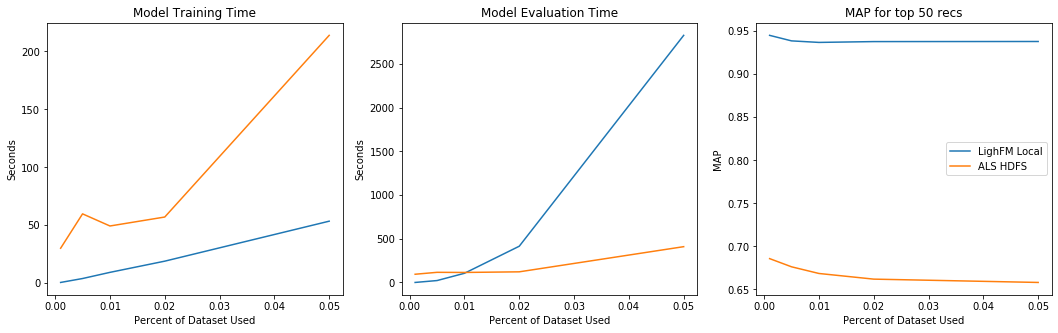

In [11]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

ax1.plot(x_label_lightfm,np.mean(train_time_lightfm,axis=1))
ax1.plot(x_label_als[:5],[np.mean(a) for a in train_time_als[:5]])
#ax1.set_xticks(x_label_lightfm)
ax1.set_title('Model Training Time')
ax1.set_ylabel('Seconds')
ax1.set_xlabel('Percent of Dataset Used')
ax2.plot(x_label_lightfm,np.mean(eval_time_lightfm,axis=1))
ax2.plot(x_label_als[:5],[np.mean(a) for a in eval_time_als[:5]])
#ax2.set_xticks(x_label_lightfm)
ax2.set_title('Model Evaluation Time')
ax2.set_ylabel('Seconds')
ax2.set_xlabel('Percent of Dataset Used')
ax3.plot(x_label_lightfm,np.mean(performance_lightfm,axis=1))
ax3.plot(x_label_als[:5],[np.mean(a) for a in performance_als[:5]])
#ax3.set_xticks(x_label_lightfm)
ax3.set_title('MAP for top 50 recs')
ax3.set_ylabel('MAP')
ax3.set_xlabel('Percent of Dataset Used')

plt.legend(['LighFM Local','ALS HDFS'])
plt.show()

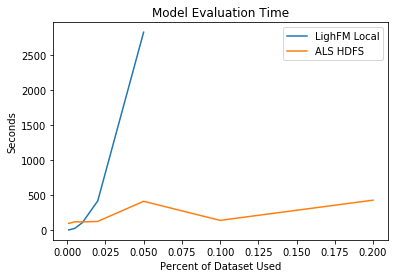

In [12]:
plt.plot(x_label_lightfm,np.mean(eval_time_lightfm,axis=1))
plt.plot(x_label_als,[np.mean(a) for a in eval_time_als])
#ax2.set_xticks(x_label)
plt.title('Model Evaluation Time')
plt.ylabel('Seconds')
plt.xlabel('Percent of Dataset Used')
plt.legend(['LighFM Local','ALS HDFS'])
plt.show()